# Tabular Variational Autoencoder
This simple tutorial shows how to train a Variational Autoencoder (VAE) on a small table and generate synthetic rows. It's designed for a non-technical audience, so follow along step by step.

## 1. Setup
Run the cell below to install the required libraries. If you're running in an environment that already has them, this step will finish quickly.

In [ ]:
%pip install torch pandas scikit-learn --quiet
%pip install seaborn  --quiet

## 2. Load a sample dataset
We'll use the classic Iris flower dataset that comes with scikit-learn.


What is the Iris Dataset:

- Collected by Edgar Anderson; made famous by Ronald Fisher in 1936.
- It contains 150 samples (rows) of iris flowers
- There are 3 species of iris in the dataset:
   1. Iris setosa (50 Samples)
   2. Iris versicolor (50 Samples)
   3. Iris virginica (50 Samples)
- Each sample has 4 features (numeric measurements):
  1. Sepal length (cm)
  2. Sepal width (cm)
  3. Petal length (cm)
  4. Petal width (cm)


# Step 1: Loading the Iris data set in Python in dataframe format

In [4]:
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

iris = load_iris()
data = pd.DataFrame(iris.data, columns=iris.feature_names)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data.head()
#data.describe()
#data.info()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,6.1,2.8,4.7,1.2
1,5.7,3.8,1.7,0.3
2,7.7,2.6,6.9,2.3
3,6.0,2.9,4.5,1.5
4,6.8,2.8,4.8,1.4


In [8]:
iris = load_iris(as_frame=True)
df = iris.frame
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## 3. Build a simple VAE
This VAE has two main parts: an encoder that compresses the data and a decoder that rebuilds it.

In [ ]:
import torch
from torch import nn

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super().__init__()

        # Encoder networks consist of two linear layers with ReLU activations
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, latent_dim*2)
        )
        # Decoder networks consist of two linear layers with ReLU activations
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=1)
        return mu, logvar
    
    # Reparameterization trick to sample from N(mu, var) from N(0,1)

    def reparameterize(self, mu, logvar):
        std = (0.5*logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.decoder(z)
# Complete forward pass
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [8]:
VAE

__main__.VAE

## 4. Train the model
We'll train for just a few epochs because the dataset is small.

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset

X = torch.tensor(data.values, dtype=torch.float32)
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

model = VAE(input_dim=X.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(50):
    for batch in loader:
        batch = batch[0]
        recon, mu, logvar = model(batch)
        recon_loss = nn.functional.mse_loss(recon, batch)
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: loss={loss.item():.4f}')


Epoch 0: loss=11.1449
Epoch 10: loss=2.1935
Epoch 20: loss=1.0104
Epoch 30: loss=1.3340
Epoch 40: loss=0.8736


In [9]:
X = torch.tensor(data.values, dtype=torch.float32)
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

## 5. Generate new synthetic rows
After training, we can sample new rows from the model.

In [13]:
for batch in loader:
    batch = batch[0]
    recon, mu, logvar = model(batch)
    break

Matplotlib is building the font cache; this may take a moment.


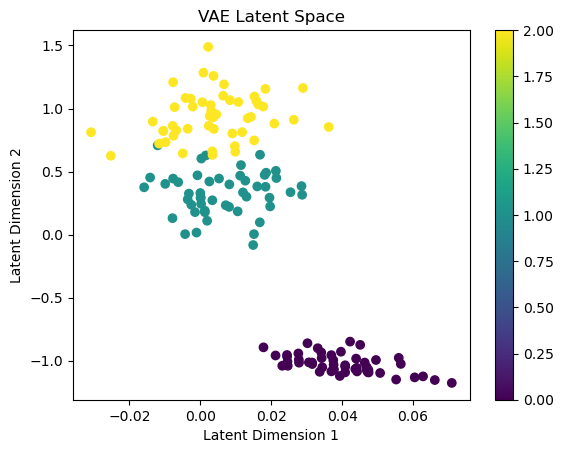

In [18]:
embed = model.encode(X)[0].detach().numpy()
import matplotlib.pyplot as plt
plt.scatter(embed[:, 0], embed[:, 1], c=iris.target)
plt.colorbar()
plt.title('VAE Latent Space')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

In [21]:
embeddings = embed
embeddings.shape

(150, 2)

In [16]:
recon.shape, mu.shape, logvar.shape


(torch.Size([16, 4]), torch.Size([16, 2]), torch.Size([16, 2]))

In [6]:
with torch.no_grad():
    z = torch.randn(5, 2)
    synthetic = model.decode(z).numpy()
synthetic_df = pd.DataFrame(synthetic, columns=iris.feature_names)
synthetic_df


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,4.973775,3.257425,1.819428,0.373154
1,7.985311,2.981492,7.748984,2.846972
2,6.866119,2.770091,6.220477,2.242729
3,5.554384,3.120963,3.140249,0.933532
4,6.048673,2.952152,4.390770,1.460567


In [21]:
data_dir = '/Users/sadegh.mohammadi/Desktop/real-toy-dataset.csv'
import pandas as pd

# Load Excel file
df = pd.read_csv(data_dir)

# Show first 5 rows
print(df.head())


  STUDYID USUBJID  BW_d1  BW_d7  BW_d14  BW_d21  BW_d28  LB_Eosinophils_L  \
0       1  1-1001  236.0  298.0   353.0   400.0   416.0              0.20   
1       1  1-1002  199.0  253.0   302.0   347.0   369.0              0.12   
2       1  1-1003  246.0  315.0   372.0   428.0   455.0              0.08   
3       1  1-1005  302.0  358.0   406.0   468.0   499.0              0.10   
4       1  1-1006  273.0  322.0   350.0   387.0   408.0              0.06   

   LB_Erythrocytes_L  LB_HCT_BLOOD  ...  OM_SPLEEN  OM_LIVER  OM_HEART  \
0               7.55          44.2  ...      0.986    15.120     1.357   
1               8.31          48.2  ...      0.704    12.451     1.333   
2               8.38          47.5  ...      0.757    16.138     1.396   
3               8.08          47.3  ...      0.831    18.750     1.633   
4               9.20          52.2  ...      0.881    13.054     1.441   

           STRAIN  SEX  YEAR        ROUTE  GLPFL  TRTVCAT  COMPANY  
0  SPRAGUE DAWLEY    M 

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   STUDYID            2362 non-null   object 
 1   USUBJID            2362 non-null   object 
 2   BW_d1              2362 non-null   float64
 3   BW_d7              2362 non-null   float64
 4   BW_d14             2362 non-null   float64
 5   BW_d21             2362 non-null   float64
 6   BW_d28             2362 non-null   float64
 7   LB_Eosinophils_L   2362 non-null   float64
 8   LB_Erythrocytes_L  2362 non-null   float64
 9   LB_HCT_BLOOD       2362 non-null   float64
 10  LB_Hemoglobin_L    2362 non-null   float64
 11  LB_Lymphocytes_L   2362 non-null   float64
 12  LB_MCHC_L          2362 non-null   float64
 13  LB_MCH_fmol        2362 non-null   float64
 14  LB_MCV_fL          2362 non-null   float64
 15  LB_Monocytes_L     2362 non-null   float64
 16  LB_Platelets_L     2362 

You're now ready to adapt this notebook to your own tables. Replace the dataset loading step with your data and retrain the model.